In [1]:
import os
from pathlib import Path
# Check if the code is running on Google Colab
try:
    import google.colab
    IN_COLAB = True
    base_path = "/content/"
    if Path(f"{base_path}final_project").is_dir():
      %cd {base_path}final_project
      !git pull
      %cd {base_path}
    else:
      !git clone https://github.com/fernandaluft/final_project.git
except ImportError:
    IN_COLAB = False
    base_path = "/workspaces/"

Cloning into 'final_project'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 84 (delta 37), reused 62 (delta 18), pack-reused 0
Receiving objects: 100% (84/84), 628.58 KiB | 13.66 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from final_project.src.scraping import Scraping
import os

In [4]:
scraping = Scraping(IN_COLAB)
scraping.kaggle_scrape()

In [5]:
limit = 200000
dataset_limit=60000

In [6]:
class Eda():
    def __init__(self, limit, dataset_limit):
        self.dataset_limit = dataset_limit
        self.limit = limit
        os.makedirs(f'{base_path}final_project/charts', exist_ok=True)
        os.makedirs(f'{base_path}final_project/preprocessed_data', exist_ok=True)

    def merge_datasets(self):
        if self.limit != None:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv').sample(self.limit)
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv').sample(self.limit)
        else:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv')
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv')
        self.books_df = self.df1.merge(self.df2, left_on='Title', right_on='Title', how='inner')
        self.books_df = self.books_df.sample(self.dataset_limit)
        self.books_df.to_csv(f"{base_path}final_project/preprocessed_data/books_reviews.csv", index=False)
        os.system(f'zip -r {base_path}final_project/preprocessed_data/books_reviews.zip {base_path}final_project/preprocessed_data/books_reviews.csv')
        os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.csv')
        command = "split -b 100M '{}' --additional-suffix=_{}".format(f'{base_path}final_project/preprocessed_data/books_reviews.zip', os.path.basename(f'{base_path}final_project/preprocessed_data/books_reviews.zip'))
        os.system(command)
        !mv {base_path}*_books_reviews.zip {base_path}final_project/preprocessed_data/
        os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.zip')

        return self.books_df

    def explore(self):
        self.books_df = pd.read_csv(f"{base_path}final_project/preprocessed_data/books_reviews.csv")
        print(f'Dataset Info:\n {self.books_df.info()}')
        print(f'Number of duplicates:\n {self.books_df.duplicated().sum()}')
        print(f'Null values:\n {self.books_df.isnull().sum()}')
        sns.heatmap(self.books_df.isnull(), annot = False)
        plt.savefig(f'{base_path}final_project/charts/heatmap_null_values.jpg')
        plt.show()
        print(self.books_df.head())
        print(self.books_df.Title.nunique())
        print(self.books_df.groupby('Title')['review/text'].count().sort_values(ascending=False).iloc[0:51])
        print(self.books_df.describe(include = np.number).T)
        print(self.books_df.describe(include = ['O']).T)

        plt.figure(figsize=(4,4))
        plt.title("Correlation Analysis of Amazon Books Reviews")
        corr = self.books_df.corr()
        sns.heatmap(corr, annot = True)
        plt.savefig(f'{base_path}final_project/charts/correlation_matrix.jpg')
        plt.show()

    def data_cleaning(self):
        self.books_df = self.books_df.drop_duplicates()
        self.books_df = self.books_df.reset_index(drop=True)
        print(f'New dataset shape:\n {self.books_df.shape}')
        print('Removing irrevelant variables...\n')
        self.books_df = self.books_df.drop(['previewLink', 'infoLink', 'Id', 'Price', 'User_id', 'profileName'], axis = 1)
        print(f'New dataset columns:\ {self.books_df.columns}')

    def univariate_variables(self):
        self.books_df_cat = self.books_df.select_dtypes(include=['O'])
        self.books_df_num = self.books_df.select_dtypes(include=np.number)
        print(f'Categorical and textual features:\n {self.books_df_cat.info()}')
        print(f'Numerical features:\n {self.books_df_num.info()}')

        fig, axis = plt.subplots(1, 3, figsize = (10, 7))
        sns.countplot(ax = axis[0], data = self.books_df_cat, x = "publisher").set(ylabel = None)
        sns.countplot(ax = axis[1], data = self.books_df_cat, x = "categories").set(ylabel = None)
        sns.countplot(ax = axis[2], data = self.books_df_cat, x = "authors").set(ylabel = None)
        plt.tight_layout()
        plt.savefig(f'{base_path}final_project/charts/plot_categorical_variables.jpg')
        plt.show()



In [7]:
eda = Eda(limit, dataset_limit)

In [8]:
%%time
books_df = eda.merge_datasets()

CPU times: user 42.2 s, sys: 4.49 s, total: 46.7 s
Wall time: 46.5 s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               59997 non-null  object 
 1   description         47199 non-null  object 
 2   authors             52130 non-null  object 
 3   image               49238 non-null  object 
 4   previewLink         53341 non-null  object 
 5   publisher           44355 non-null  object 
 6   publishedDate       52817 non-null  object 
 7   infoLink            53341 non-null  object 
 8   categories          49031 non-null  object 
 9   ratingsCount        32911 non-null  float64
 10  Id                  60000 non-null  object 
 11  Price               9662 non-null   float64
 12  User_id             48643 non-null  object 
 13  profileName         48642 non-null  object 
 14  review/helpfulness  60000 non-null  object 
 15  review/score        60000 non-null  float64
 16  revi

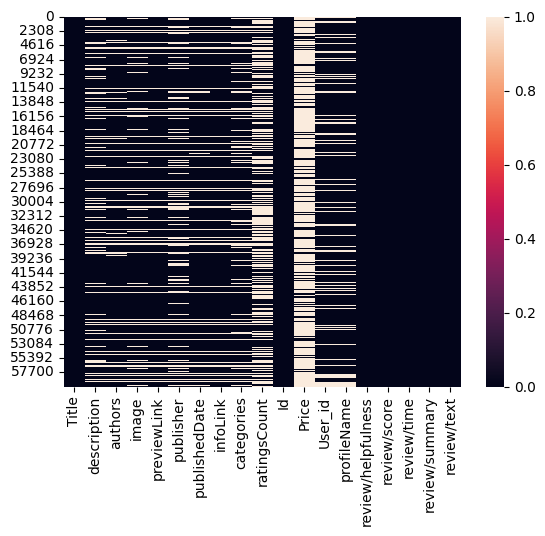

                                               Title  \
0              The Barbecue! Bible: Over 500 Recipes   
1                            Life on the Mississippi   
2  Moby Dick;: Or, The white whale (A Signet clas...   
3                                   Love You Forever   
4                                        Salem Falls   

                                         description               authors  \
0  Now the biggest and the best recipe collection...   ['Steven Raichlen']   
1  Offers a history of the river, describes Twain...        ['Mark Twain']   
2  For this Sesquicentennial Norton Critical Edit...   ['Herman Melville']   
3  As her son grows up from little boy to adult m...  ['Robert N. Munsch']   
4  When Jack St. Bride arrives by chance in the s...      ['Jodi Picoult']   

                                               image  \
0  http://books.google.com/books/content?id=JWoOI...   
1  http://books.google.com/books/content?id=ZazQA...   
2  http://books.google.com

<ipython-input-5-49937c16cc7e>:36: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = self.books_df.corr()


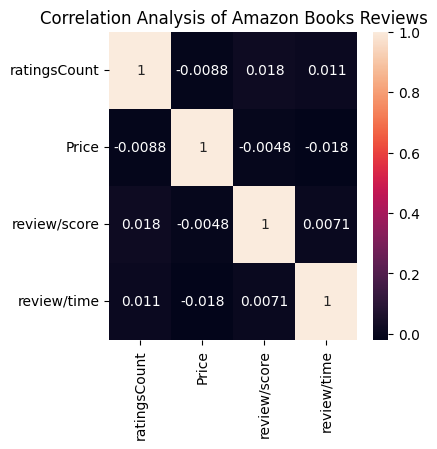

In [ ]:
eda.explore()

In [ ]:
eda.data_cleaning()

New dataset shape:
 (59994, 19)
Removing irrevelant variables...

New dataset columns:\ Index(['Title', 'description', 'authors', 'image', 'publisher',
       'publishedDate', 'categories', 'ratingsCount', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


In [ ]:
eda.univariate_variables()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59994 entries, 0 to 59993
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               59991 non-null  object
 1   description         47193 non-null  object
 2   authors             52124 non-null  object
 3   image               49232 non-null  object
 4   publisher           44350 non-null  object
 5   publishedDate       52811 non-null  object
 6   categories          49025 non-null  object
 7   review/helpfulness  59994 non-null  object
 8   review/summary      59992 non-null  object
 9   review/text         59994 non-null  object
dtypes: object(10)
memory usage: 4.6+ MB
Categorical and textual features:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59994 entries, 0 to 59993
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ratingsCount  32907 non-null  float

<ipython-input-5-49937c16cc7e>:59: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from current font.
  plt.tight_layout()
<ipython-input-5-49937c16cc7e>:59: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  plt.tight_layout()
<ipython-input-5-49937c16cc7e>:59: UserWarning: Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from current font.
  plt.tight_layout()
<ipython-input-5-49937c16cc7e>:59: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  plt.tight_layout()
<ipython-input-5-49937c16cc7e>:59: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  plt.tight_layout()
<ipython-input-5-49937c16cc7e>:59: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  plt.tight_layout()
<ipython-input-5-49937c16cc7e>:59: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  plt.tight_layout()
<ipython-input-5-49937c16cc7e>:59: UserWa

In [ ]:
len(books_df)

186826

In [ ]:
%cd {base_path}final_project
!git config --global --unset credential.helper
#!git config --global user.name "fernandaluft"
#!git config --global user.email "fernandaluft@gmail.com"
#!git config --global user.name "neural1977"
#!git config --global user.email "pugliese05@gmail.com"
!git add .
!git commit -m "New Final Project"


/content/final_project
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address
